<h1>Get the number of pages</h1>

In [1]:
import requests
from bs4 import BeautifulSoup
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import re
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import to_date,col,date_format,sort_array
from datetime import datetime
import os
from dotenv import load_dotenv
import logging
from pyspark.sql.functions import sum, count
import matplotlib.pyplot as plt 
from pyspark.sql import functions as F

In [2]:
logging.basicConfig(
    filename='log.txt',
    level=logging.ERROR,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filemode='a'
)

<p>We set up the url of our page. we can change the years of game releases, as well as their platform and many other criteria</p>

In [3]:
url = f'https://www.metacritic.com/browse/game/?releaseYearMin=2021&releaseYearMax=2024&page='

In [4]:
def get_number_pages(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url+"1", headers=headers)
    
    # if the request was successful
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        game_presence = soup.find('div',class_='c-finderProductCard')
        if game_presence is not None:
            try:
                number_page = soup.find('span',class_='c-navigationPagination_pages').find_all('span','c-navigationPagination_itemButtonContent')[-1]
                number_page = number_page.text.strip()
                print(number_page,"pages found")
                return int(number_page)
            except Exception as e:
                print("1 page found")
                return 1
        else:
            print("No games found")
            return -1
    else:
        print(f"Erreur {response.status_code}")
        return -1

In [5]:
number_page = get_number_pages(url)

75 pages found


<h1>Get the content of each page</h1>

In [6]:
#Function that, for a page number passed as parameter, will retrieve the content of the associated page
def fetch_page_data(numpage):
    #time.sleep(2)
    if numpage > 0:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        try:
            response = requests.get(url+str(numpage), headers=headers, timeout=10)
            response.raise_for_status()
            return numpage, response.text
        except HTTPError as http_err:
            print(f"HTTP Error for page {numpage}: {http_err}")
        except Timeout:
            print(f"Timeout for page {numpage}")
        except RequestException as req_err:
            print(f"Request error for page {numpage}: {req_err}")
    return numpage, "NULL"

In [7]:
def create_tab_request(number_page):
    if number_page>0:
        html_content_tab_request = []
        # Using ThreadPoolExecutor for multithreading to speed up the process
        # For each page number from 1 to number_page, we call the fetch_page_data function and add the result in our result table
        with ThreadPoolExecutor(max_workers=20) as executor:
            # Submit tasks for each page
            futures = [executor.submit(fetch_page_data, numpage) for numpage in range(1, int(number_page) + 1)]
        
            # Wait for each task to be completed and retrieve the results
            for future in as_completed(futures):
                numpage, content = future.result()  # Get page number and content
                html_content_tab_request.append(content)
        return html_content_tab_request
    else:
        print("Negative page number")
        return []

In [8]:
html_content_tab_request = create_tab_request(number_page)

<h1>Get game titles</h1>

In [9]:
#we get the info from all games
def get_game_titles(html_content_tab_request):
    titles = []
    if len(html_content_tab_request) > 0 and html_content_tab_request is not None:
        for html_page in html_content_tab_request:
            soup = BeautifulSoup(html_page, 'html.parser')
        
            links = soup.find_all('a',class_='c-finderProductCard_container')
            
            for element in links:
                title_no_transform = element.get('href')
                parts = title_no_transform.split("/")
                truncated_string = parts[2]
                titles.append(truncated_string)
    else:
        print("the array passed as a parameter is empty")
    return titles

In [10]:
titles = get_game_titles(html_content_tab_request)

In [11]:
print(len(titles))

1795


<h1>Get game infos</h1>

In [12]:
def get_game_info(title):
    #time.sleep(2)
    url = f'https://www.metacritic.com/game/{title}/'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    # Récupérer la page
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Unknown page for {title}")
        return create_error_response(title)

    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Retrieve game data
    metascore = get_metascore(title,soup)
    userscore = get_userscore(title,soup)
    reviews_number = get_reviews_number(title,soup)
    release_date = get_release_date(title,soup)
    genre = get_genre(title,soup)
    developer = get_developer(title,soup)
    publisher = get_publisher(title,soup)
    platforms = get_platforms(title,soup)

    return [title, metascore, userscore, reviews_number, release_date, genre, developer,publisher, platforms]

In [13]:
def create_error_response(title):
    # Returns a list with error values ​​for the game
    return [title, "-1", "-1", "-1","NULL", "NULL", "NULL", "NULL", ["NULL"]]

In [14]:
def get_metascore(title,soup):
    # Get the metascore of the game
    try:
        metascore = soup.find('div', class_='c-siteReviewScore').find('span')
        return metascore.text
    except Exception as e:
        logging.error(f"Game : {title} - Error missing metascore : {e}")
        return "-1"

In [15]:
def get_userscore(title,soup):
    #Get the userscore of the game
    try:
        userscore = soup.find('div', class_='c-siteReviewScore_user').find('span')
        #if the game doesn't have userscore ("tbd" value)
        if userscore.text=="tbd":
            return -1
        else:
            return userscore.text
    except Exception as e:
        #if the game doesn't have userscore (div userscore not exist)
        logging.error(f"Game : {title} - Error missing userscore : {e}")
        return "-1"

In [16]:
def get_reviews_number(title,soup):
    #Get user reviews of the game 
    try:
        reviews_number = soup.find_all('span', class_='c-productScoreInfo_reviewsTotal')[1].find('span').text
        # Extract only the numbers
        match = re.search(r'\d+', reviews_number.replace(',', ''))
        return match.group(0) if match else "NULL"
    except Exception as e:
        logging.error(f"Game : {title} - Missing user review : {e}")
        return "0"

In [17]:
def get_release_date(title,soup):
    # Get the release date of the game
    try:
        release_date = soup.find_all('div', class_='g-text-xsmall')[1].find('span', class_='u-text-uppercase')
        return release_date.text if release_date else "error"
    except Exception as e:
        logging.error(f"Game : {title} - Error missing release date : {e}")
        return "NULL"

In [18]:
def get_genre(title,soup):
    #Get the genre of the game
    try:
        genre = soup.find('li', class_='c-genreList_item').find('span', class_='c-globalButton_label')
        return genre.text.strip() if genre else "error"
    except Exception as e:
        logging.error(f"Game : {title} - Error missing genre : {e}")
        return "NULL"

In [19]:
def get_developer(title,soup):
    #Get developers of the game
    try:
        developer = soup.find('div', class_='c-gameDetails_Developer').find('li', class_='c-gameDetails_listItem')
        return developer.text.strip() if developer else "error"
    except Exception as e:
        logging.error(f"Game : {title} - Error missing developer : {e}")
        return "NULL"


In [20]:
def get_publisher(title,soup):
    #Get publisher of the game
    try:
        publisher = soup.find('div', class_='c-gameDetails_Distributor').find_all('span')[1]
        return publisher.text.strip() if publisher else "error"
    except Exception as e:
        logging.error(f"Game : {title} - Error missing pubisher : {e}")
        return "NULL"


In [21]:
def get_platforms(title,soup):
    #Get platforms of the game
    try:
        platforms_list = soup.find('div', class_='c-gameDetails_Platforms').find_all('li')
        return [platform.text.strip() for platform in platforms_list] if platforms_list else ["error"]
    except Exception as e:
        logging.error(f"Game : {title} - Error missing plateforms: {e}")
        return ["NULL"]

In [22]:
def fetch_all_games_info(titles):
    game_info_list = []

    # Using ThreadPoolExecutor to run in parallel
    with ThreadPoolExecutor(max_workers=30) as executor:
        # Submit tasks to be performed for each title
        future_to_game_info = {executor.submit(get_game_info, title): title for title in titles}

        # Collect results as soon as they are ready
        for future in as_completed(future_to_game_info):
            game_info = future_to_game_info[future]
            try:
                data = future.result()
                if data != "error":
                    game_info_list.append(data)
            except Exception as e:
                logging.error(f"{game_info} generated an exception: {e}")
    return game_info_list

In [23]:
all_game_infos = fetch_all_games_info(titles)

<h1>Data cleaning</h1>

In [24]:
load_dotenv()

aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')

conf = (
    SparkConf()
    .setAppName("MY_APP") # replace with your desired name
    .set("spark.jars.packages", "io.delta:delta-core_2.12:2.3.0,org.apache.hadoop:hadoop-aws:3.3.2")
    .set("spark.sql.catalog.spark_catalog","org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .set("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .set("spark.hadoop.fs.s3a.access.key", aws_access_key_id)
    .set("spark.hadoop.fs.s3a.secret.key", aws_secret_access_key)
    .set("spark.sql.shuffle.partitions", "10")
    .setMaster("local[*]")
)

spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

24/09/16 03:05:58 WARN Utils: Your hostname, MacBook-Air-de-Geoffrey.local resolves to a loopback address: 127.0.0.1; using 10.245.55.173 instead (on interface en0)
24/09/16 03:05:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/gvillevy/.ivy2/cache
The jars for the packages stored in: /Users/gvillevy/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-20d337cb-913f-4e3e-b5dd-b8abafd476e9;1.0
	confs: [default]


:: loading settings :: url = jar:file:/Users/gvillevy/anaconda3/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found io.delta#delta-core_2.12;2.3.0 in central
	found io.delta#delta-storage;2.3.0 in central
	found org.antlr#antlr4-runtime;4.8 in central
	found org.apache.hadoop#hadoop-aws;3.3.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.1026 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 144ms :: artifacts dl 5ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.1026 from central in [default]
	io.delta#delta-core_2.12;2.3.0 from central in [default]
	io.delta#delta-storage;2.3.0 from central in [default]
	org.antlr#antlr4-runtime;4.8 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.2 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	------

In [25]:
#We create our dataframe with our information
df = spark.createDataFrame(all_game_infos, ["title","metascore","userscore","reviews_number","date","genre","developer","publisher","plateforms"])
df.show()

+--------------------+---------+---------+--------------+------------+--------------------+--------------------+--------------------+--------------------+
|               title|metascore|userscore|reviews_number|        date|               genre|           developer|           publisher|          plateforms|
+--------------------+---------+---------+--------------+------------+--------------------+--------------------+--------------------+--------------------+
|chicory-a-colorfu...|       90|      7.5|           114|Jun 10, 2021|           Adventure|        Greg Lobanov|               Finji|[PC, PlayStation ...|
|         jack-jeanne|       90|      7.3|            52|Jun 15, 2023|        Visual Novel|            Broccoli|         Aksys Games|[Nintendo Switch,...|
|      dave-the-diver|       90|      8.2|           600|Jun 28, 2023|    Action Adventure|         MINT ROCKET|         MINT ROCKET|[PC, Nintendo Swi...|
|          videoverse|       90|      6.9|            17| Aug 7, 2023|

In [26]:
# Convert 'date' column in DateType format directly to ISO 8601
df = df.withColumn("date", to_date(col("date"), "MMM d, yyyy"))

df.show()

+--------------------+---------+---------+--------------+----------+--------------------+--------------------+--------------------+--------------------+
|               title|metascore|userscore|reviews_number|      date|               genre|           developer|           publisher|          plateforms|
+--------------------+---------+---------+--------------+----------+--------------------+--------------------+--------------------+--------------------+
|chicory-a-colorfu...|       90|      7.5|           114|2021-06-10|           Adventure|        Greg Lobanov|               Finji|[PC, PlayStation ...|
|         jack-jeanne|       90|      7.3|            52|2023-06-15|        Visual Novel|            Broccoli|         Aksys Games|[Nintendo Switch,...|
|      dave-the-diver|       90|      8.2|           600|2023-06-28|    Action Adventure|         MINT ROCKET|         MINT ROCKET|[PC, Nintendo Swi...|
|          videoverse|       90|      6.9|            17|2023-08-07|           Adv

In [27]:
#We transform our string into the appropriate type
df = df.withColumn("metascore", col("metascore").cast("int"))
df = df.withColumn("reviews_number", col("reviews_number").cast("int"))
df = df.withColumn("userscore", col("userscore").cast("float"))

# Show DataFrame schema to check column types
df.printSchema()

root
 |-- title: string (nullable = true)
 |-- metascore: integer (nullable = true)
 |-- userscore: float (nullable = true)
 |-- reviews_number: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- genre: string (nullable = true)
 |-- developer: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- plateforms: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [28]:
# Sort platforms in the 'platforms' column alphabetically
df = df.withColumn("plateforms", sort_array(col("plateforms")))

In [29]:
# Delete rows containing NULLs in any column
df = df.dropna()
df.show()

+--------------------+---------+---------+--------------+----------+--------------------+--------------------+--------------------+--------------------+
|               title|metascore|userscore|reviews_number|      date|               genre|           developer|           publisher|          plateforms|
+--------------------+---------+---------+--------------+----------+--------------------+--------------------+--------------------+--------------------+
|chicory-a-colorfu...|       90|      7.5|           114|2021-06-10|           Adventure|        Greg Lobanov|               Finji|[Nintendo Switch,...|
|         jack-jeanne|       90|      7.3|            52|2023-06-15|        Visual Novel|            Broccoli|         Aksys Games|[Nintendo Switch,...|
|      dave-the-diver|       90|      8.2|           600|2023-06-28|    Action Adventure|         MINT ROCKET|         MINT ROCKET|[Nintendo Switch,...|
|          videoverse|       90|      6.9|            17|2023-08-07|           Adv

In [30]:
total_jeux_traites = df.count()
total_jeux = len(titles)
print("total games :",total_jeux)
print("total games processed:",total_jeux_traites)
print(int((total_jeux_traites/total_jeux)*100),"% games were kept after transformation")

total games : 1795
total games processed: 1791
99 % games were kept after transformation


In [31]:
liste_titre_jeux_traite = df.select("title").rdd.flatMap(lambda x: x).collect()

diff1 = [item for item in titles if item not in liste_titre_jeux_traite]
print("In titles but not in the final df:", diff1)

In titles but not in the final df: ['rose-and-camellia-collection', 'super-mario-party-jamboree', 'silent-hill-2', 'the-legend-of-zelda-echoes-of-wisdom']


<h1>Upload to a S3 Bucket</h1>

In [32]:
bucket_name = "videogames-project"

# Get the day
today = datetime.today().date()

# Format the date as 'YYYY-MM-DD'
formatted_date = today.strftime('%Y-%m-%d')

path = f"s3a://{bucket_name}/dataset-{today}/" 

df.write.mode("overwrite").parquet(path)

<h1>Datas visualization</h1>

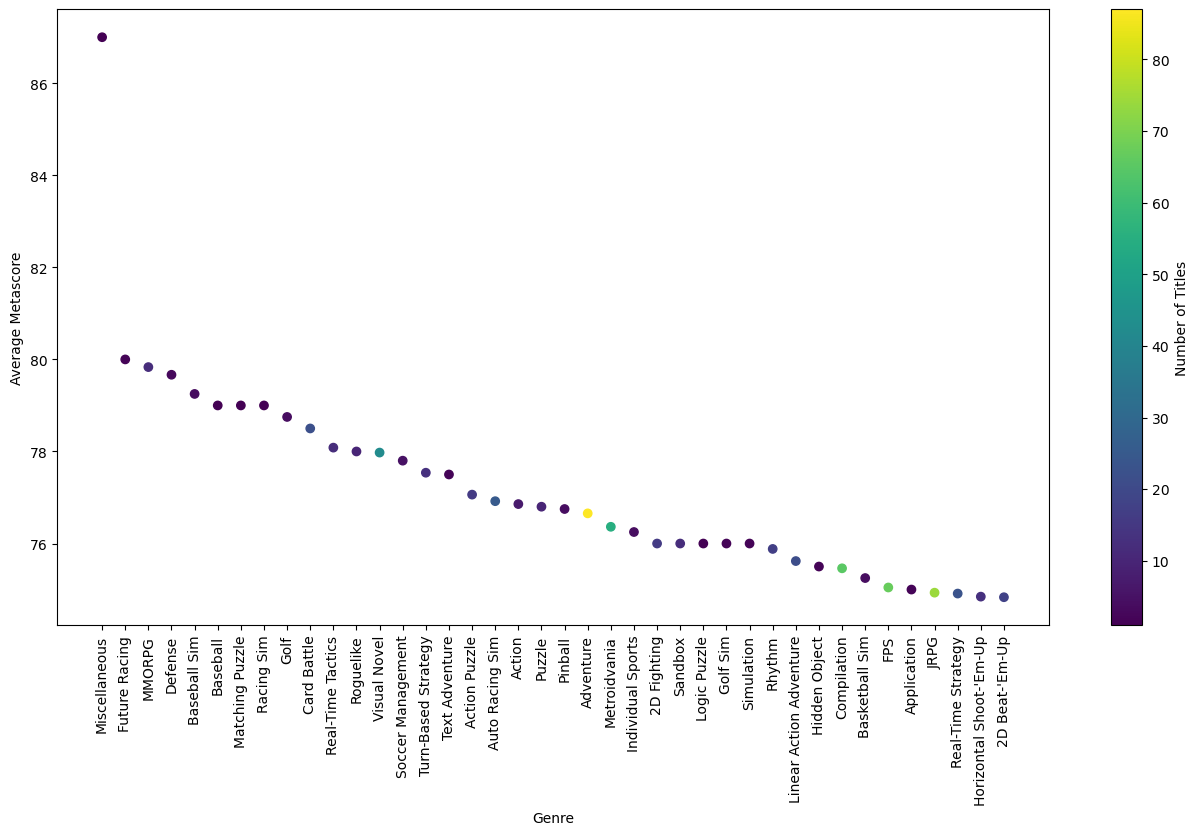

In [50]:
# Obtenir les moyennes des metascores par genre et compter les titres
df_age_metascore_per_genre = df.groupBy("genre") \
    .agg(F.avg("metascore").alias("avg_metascore"), F.count("title").alias("count"))

# Ordonner par la moyenne des metascores
df_age_metascore_per_genre = df_age_metascore_per_genre.orderBy("avg_metascore", ascending=False)

# Convertir en DataFrame Pandas
df_pandas = df_age_metascore_per_genre.toPandas().head(40)

# Créer le graphique avec une taille augmentée
plt.figure(figsize=(16, 8))

# Tracer les données avec une couleur basée sur le 'count'
scatter = plt.scatter(df_pandas["genre"], df_pandas["avg_metascore"], 
                      c=df_pandas["count"], cmap='viridis')

plt.xlabel("Genre")
plt.ylabel("Average Metascore")
plt.xticks(rotation=90) 
plt.colorbar(scatter, label="Number of Titles")

plt.show()


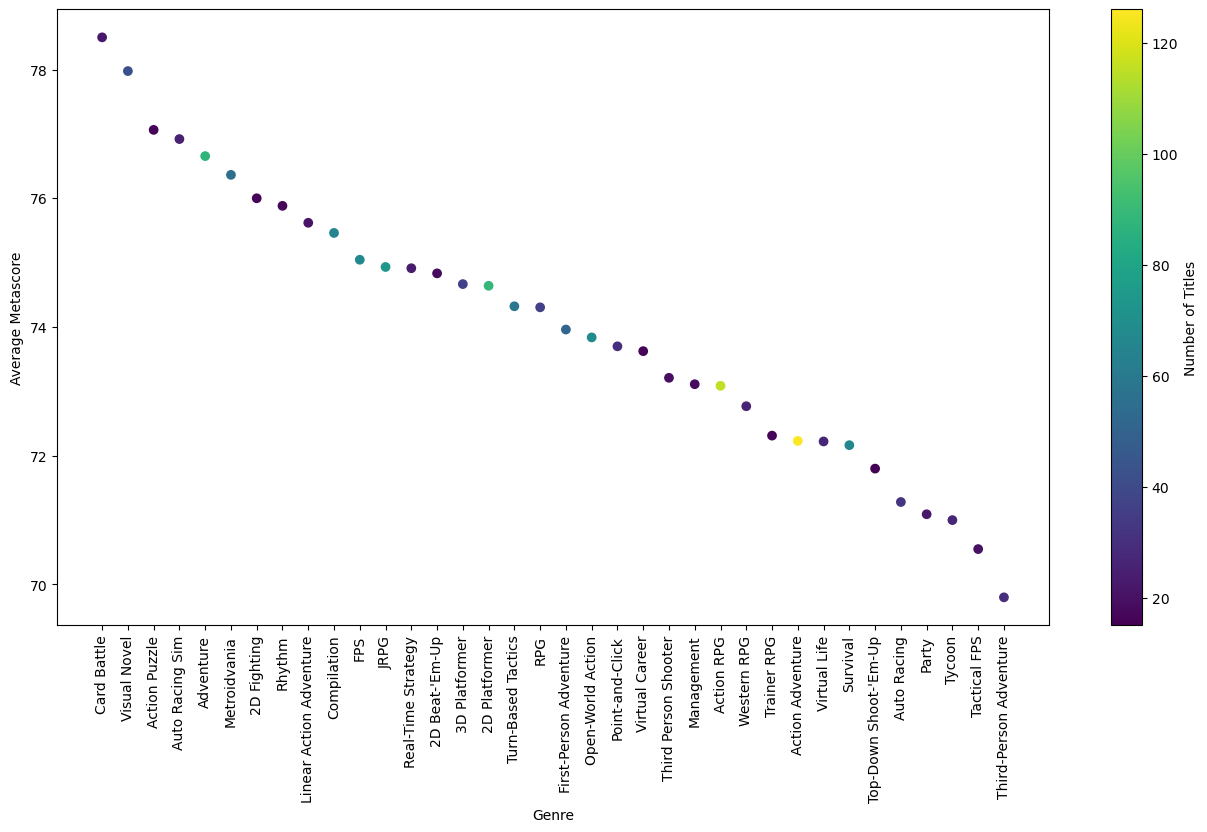

In [54]:
df_age_metascore_per_genre_50_games = df_age_metascore_per_genre.filter(col("count") >= 15)

df_pandas_df_age_metascore_per_genre_50_games = df_age_metascore_per_genre_50_games.toPandas().head(40)

# Créer le graphique avec une taille augmentée
plt.figure(figsize=(16, 8))

# Tracer les données avec une couleur basée sur le 'count'
scatter = plt.scatter(df_pandas_df_age_metascore_per_genre_50_games["genre"], df_pandas_df_age_metascore_per_genre_50_games["avg_metascore"], 
                      c=df_pandas_df_age_metascore_per_genre_50_games["count"], cmap='viridis')

plt.xlabel("Genre")
plt.ylabel("Average Metascore")
plt.xticks(rotation=90)
plt.colorbar(scatter, label="Number of Titles")

plt.show()

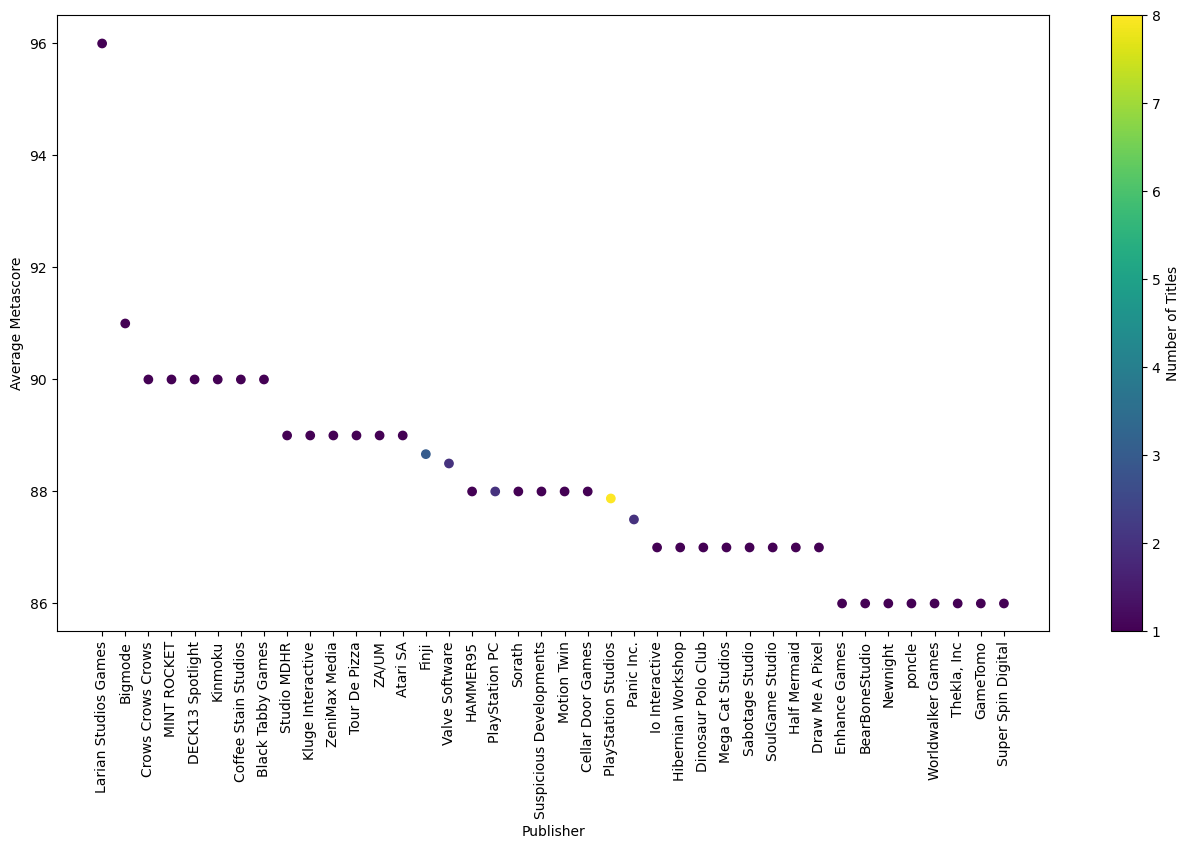

In [55]:
# Obtenir les moyennes des metascores par genre et compter les titres
df_age_metascore_per_publisher = df.groupBy("publisher") \
    .agg(F.avg("metascore").alias("avg_metascore"), F.count("title").alias("count"))

# Ordonner par la moyenne des metascores
df_age_metascore_per_publisher = df_age_metascore_per_publisher.orderBy("avg_metascore", ascending=False)

# Convertir en DataFrame Pandas
df_pandas_df_age_metascore_per_publisher = df_age_metascore_per_publisher.toPandas().head(40)

# Créer le graphique avec une taille augmentée
plt.figure(figsize=(16, 8))

# Tracer les données avec une couleur basée sur le 'count'
scatter = plt.scatter(df_pandas_df_age_metascore_per_publisher["publisher"], df_pandas_df_age_metascore_per_publisher["avg_metascore"], 
                      c=df_pandas_df_age_metascore_per_publisher["count"], cmap='viridis')

plt.xlabel("Publisher")
plt.ylabel("Average Metascore")
plt.xticks(rotation=90)
plt.colorbar(scatter, label="Number of Titles")

plt.show()


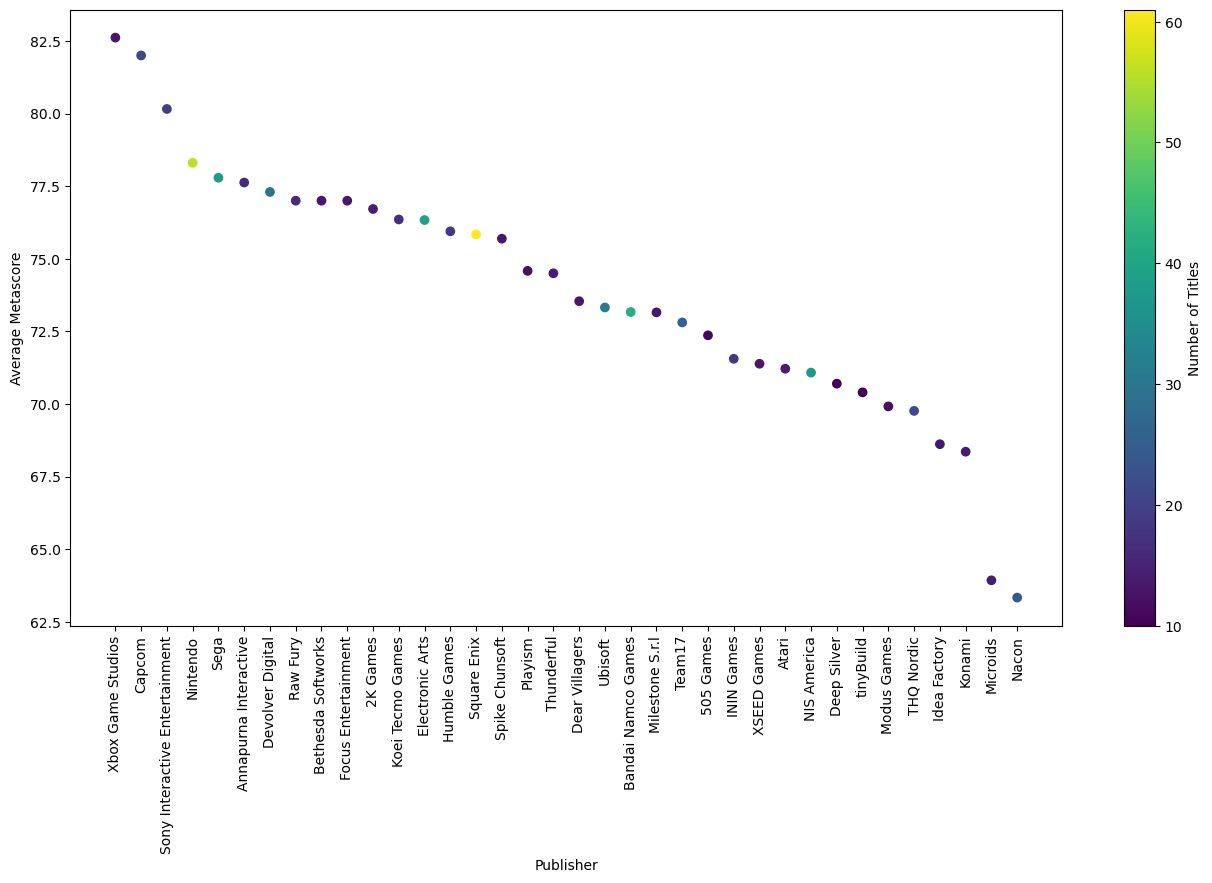

In [56]:
df_age_metascore_per_publisher_50_games = df_age_metascore_per_publisher.filter(col("count") >= 10)
df_pandas_df_age_metascore_per_publisher_50_games = df_age_metascore_per_publisher_50_games.toPandas().head(40)

# Créer le graphique avec une taille augmentée
plt.figure(figsize=(16, 8))

# Tracer les données avec une couleur basée sur le 'count'
scatter = plt.scatter(df_pandas_df_age_metascore_per_publisher_50_games["publisher"], df_pandas_df_age_metascore_per_publisher_50_games["avg_metascore"], 
                      c=df_pandas_df_age_metascore_per_publisher_50_games["count"], cmap='viridis')

plt.xlabel("Publisher")
plt.ylabel("Average Metascore")
plt.xticks(rotation=90) 
plt.colorbar(scatter, label="Number of Titles")

plt.show()


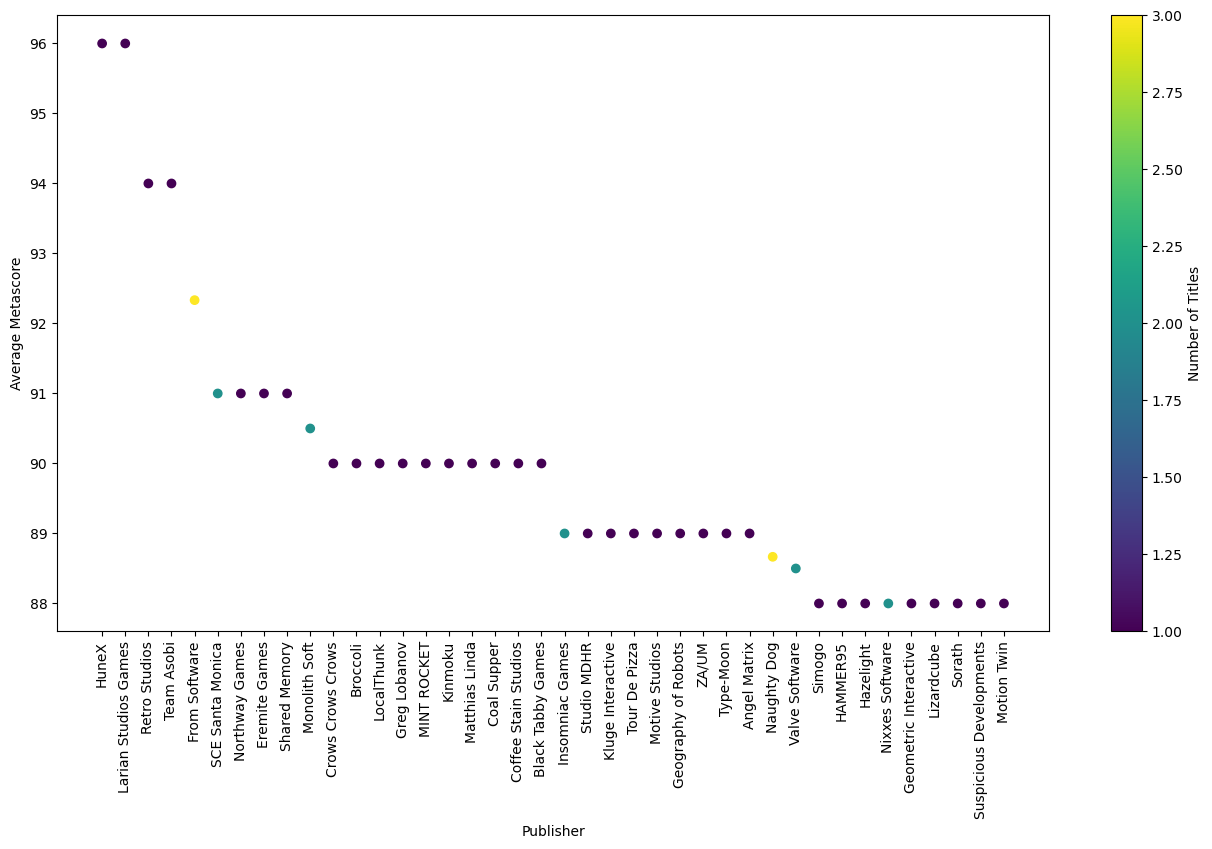

In [58]:
# Obtenir les moyennes des metascores par genre et compter les titres
df_age_metascore_per_developer = df.groupBy("developer") \
    .agg(F.avg("metascore").alias("avg_metascore"), F.count("title").alias("count"))

# Ordonner par la moyenne des metascores
df_age_metascore_per_developer = df_age_metascore_per_developer.orderBy("avg_metascore", ascending=False)

# Convertir en DataFrame Pandas
df_pandas_df_age_metascore_per_developer = df_age_metascore_per_developer.toPandas().head(40)

# Créer le graphique avec une taille augmentée
plt.figure(figsize=(16, 8))

# Tracer les données avec une couleur basée sur le 'count'
scatter = plt.scatter(df_pandas_df_age_metascore_per_developer["developer"], df_pandas_df_age_metascore_per_developer["avg_metascore"], 
                      c=df_pandas_df_age_metascore_per_developer["count"], cmap='viridis')

plt.xlabel("Publisher")
plt.ylabel("Average Metascore")
plt.xticks(rotation=90)
plt.colorbar(scatter, label="Number of Titles")

plt.show()


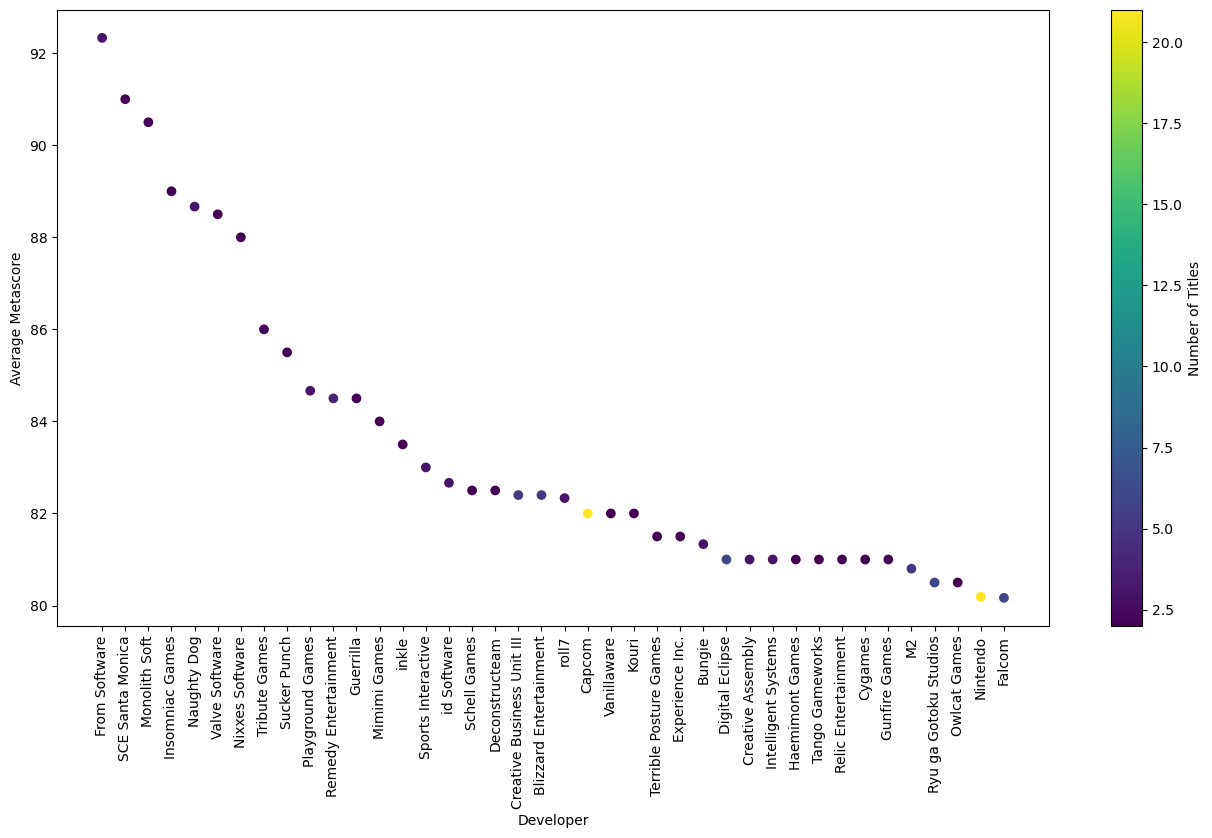

In [61]:
df_age_metascore_per_developer_50_games = df_age_metascore_per_developer.filter(col("count") >= 2)
df_pandas_df_age_metascore_per_developer_50_games = df_age_metascore_per_developer_50_games.toPandas().head(40)

# Créer le graphique avec une taille augmentée
plt.figure(figsize=(16, 8))

# Tracer les données avec une couleur basée sur le 'count'
scatter = plt.scatter(df_pandas_df_age_metascore_per_developer_50_games["developer"], df_pandas_df_age_metascore_per_developer_50_games["avg_metascore"], 
                      c=df_pandas_df_age_metascore_per_developer_50_games["count"], cmap='viridis')

plt.xlabel("Developer")
plt.ylabel("Average Metascore")
plt.xticks(rotation=90) 
plt.colorbar(scatter, label="Number of Titles")

plt.show()
